<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/14_9_semantic_segmentation_and_the_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00


## 14.9 Semantic Segmentation and the Dataset

### 14.9.2 The Pascal VOC2012 Semantic Segmentation Dataset

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [4]:
def read_voc_images(voc_dir, is_train=True):
  txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                           'train.txt' if is_train else 'val.txt')
  mode = torchvision.io.ImageReadMode.RGB
  with open(txt_fname, 'r') as f:
    images = f.read().split()
  features, labels = [], []
  for i, fname in enumerate(images):
    features.append(torchvision.io.read_image(os.path.join(
        voc_dir, 'JPEGImages', f'{fname}.jpg')))
    labels.append(torchvision.io.read_image(os.path.join(
        voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
  return features, labels

In [5]:
train_features, train_labels = read_voc_images(voc_dir, True)

torch.Size([3, 281, 500])

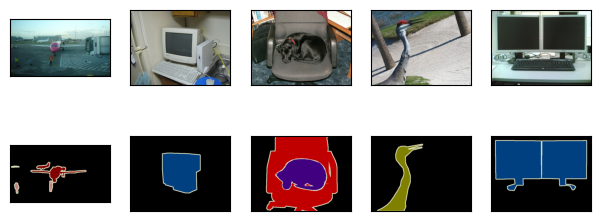

In [22]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);
train_labels[0].shape

In [7]:
# All the colors presented in the labels images. including black for background and whitle for borders.
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

# All the classes in the dataset (21)
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [8]:
def voc_colormap2label():
  """build the mapping from RGB to class indices for VOC labels."""
  colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
  for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[
        (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
  return colormap2label

def voc_label_indices(colormap, colormap2label):
  """Map any RGB values in VOC labels to their class indices."""
  colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
  idx = ((colormap[:, :, 0] *256 + colormap[:, :, 1]) * 256
         + colormap[:, :, 2])
  return colormap2label[idx]

In [9]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105: 115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

#### Data Preprocessing

In [23]:
def voc_rand_crop(feature, label, height, width):
  """Randomly crop both feature and label images."""
  rect = torchvision.transforms.RandomCrop.get_params(
      feature, (height, width))
  feature = torchvision.transforms.functional.crop(feature, *rect)
  label = torchvision.transforms.functional.crop(label, *rect)
  return feature, label

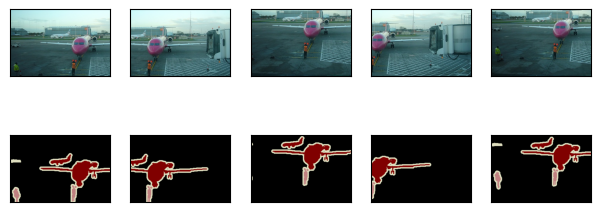

In [25]:
imgs = []
for _ in range(n):
  imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);